In [1]:
import os
from datetime import datetime
import pandas as pd
import collections
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
EPSILON = 0.01

In [3]:
def weighted_median(data, weights):

    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

In [11]:
class NooksExperiment:
    '''
        initializes the network graph which keeps track of all the interactions in nooks
                        nooks graph which tracks the members talking in a single day
    '''
    def _init_graphs(self):
        self.network_graph = nx.Graph()
        self.nooks_graph = nx.Graph()
        
        nft = len(self.member_vectors[0])
        self.graph_colors = []
        
        if nft == 1:
            color = self.member_vectors
        else:
            pca = PCA(n_components=1)
            color = pca.fit_transform(self.member_vectors)
        
        self.graph_colors = color.reshape(-1)
            
        for member in range(self.total_members):
            self.network_graph.add_node(member)
            self.nooks_graph.add_node(member)
    '''
        create a class for the experiment 
            member_vectors: a M x D numpy array where M is the number of members and D is the feature representation
            alpha : the importance placed on heterophily compared to the past interaction rate
    '''
        
    def __init__(self, member_vectors, alpha):
        self.total_members = len(member_vectors)
        self.member_vectors = member_vectors
        self.interacted = np.zeros((self.total_members, self.total_members))
        self.all_interactions = np.zeros((self.total_members, self.total_members))
        self.alpha = alpha
        self._init_graphs()
        
        self.network_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Network/"
        self.nooks_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Nooks/"
        self.info_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Info/" 
        os.makedirs(self.network_output_folder)
        os.makedirs(self.nooks_output_folder)
        os.makedirs(self.info_output_folder)
        
    '''
        resets the interactions (for eg at the end of every week)
    '''
    
    def reset(self):
        self.interacted = np.zeros((self.total_members, self.total_members))
    
    '''
        called to update the interactions, also updates the total interactions during the experiment
    
    '''
    def _update_interacted(self, member_allocs, nooks_allocs):
        for member in range(self.total_members):
            if not member in member_allocs:
                continue
            self.interacted[member] += nooks_allocs[member_allocs[member]]
            self.all_interactions[member] += nooks_allocs[member_allocs[member]]
    
    # TODO see if running median is needed; space & time 
    def _create_nook_allocs_it(self, num_nooks, nook_creators, nook_swipes, num_iters=200):
        
        nooks_allocs = np.zeros((num_nooks, self.total_members))
        member_allocs = {}
        creators = set([])
        nooks_mem_cnt = np.ones((num_nooks))
        nooks_mem_int_cnt = np.zeros((num_nooks, self.total_members))
                            
        # allocates the creator to their respective nooks
        for nook in range(num_nooks):
            nooks_allocs[nook][nook_creators[nook]] = 1
            member_allocs[nook_creators[nook]] = nook
            creators.add(nook_creators[nook])
        
        # iteratively add members to nooks
        for member in range(self.total_members):
            if member in member_allocs or not(np.sum(nook_swipes[member])):
                continue
            
            swipes = nook_swipes[member]
            median_reps = []
            selected_nook = np.random.choice(num_nooks, p=swipes/np.sum(swipes))
            nooks_allocs[selected_nook][member] = 1
            member_allocs[member] = selected_nook
            nooks_mem_cnt[selected_nook] += 1
            nooks_mem_int_cnt += (self.interacted[member] >= 1)
            
        all_members_permute = np.random.permutation(self.total_members)
        for i in range(num_iters):
            
            for member in all_members_permute:
                if member in creators or not(np.sum(nook_swipes[member])):
                    continue
            
                swipes = nook_swipes[member]
                median_reps = []
            
            
                for nook in range(num_nooks):
                    if not nook_swipes[member][nook]:
                        median_reps.append(1) # this value will be ignored
                        continue
                    median_rep = np.median(self.member_vectors[nooks_allocs[nook]==1], axis=0)
                    median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
            
                heterophily = (np.array(median_reps))
                interacted_by = nooks_mem_int_cnt[:, member] 
                wts = ((EPSILON + interacted_by)/nooks_mem_cnt) * (1 + self.alpha * heterophily)
                
                sel_wts = wts * nook_swipes[member]
                
                total_sel_wts = np.sum(sel_wts)
                selected_nook = np.argmax(sel_wts/total_sel_wts)
                og_nook = member_allocs[member]
                if not(selected_nook == og_nook):
                    
                    nooks_allocs[selected_nook][member] = 1
                    nooks_allocs[og_nook][member] = 0
                    
                    nooks_mem_cnt[selected_nook] += 1
                    nooks_mem_cnt[og_nook] -= 1
                    
                    
                    member_allocs[member] = selected_nook
                    nooks_mem_int_cnt[selected_nook] += (self.interacted[member] >= 1)
                    nooks_mem_int_cnt[og_nook] -= (self.interacted[member] >= 1)
                    
                    
                #np.random.choice(num_nooks, p=sel_wts/total_sel_wts)
            
                
                
                
                
            
            
        self._update_interacted(member_allocs, nooks_allocs)
        return member_allocs, nooks_allocs
    
    
    
    '''
        creates the nook allocations in an iterative manner.
        assumes that 1 creator has only created 1 nook
    
    '''
    # TODO see if running median is needed; space & time 
    def _create_nook_allocs(self, num_nooks, nook_creators, nook_swipes):
        
        nooks_allocs = np.zeros((num_nooks, self.total_members))
        member_allocs = {}
        nooks_mem_cnt = np.ones((num_nooks))
        nooks_mem_int_cnt = np.zeros((num_nooks, self.total_members))
                            
        # allocates the creator to their respective nooks
        for nook in range(num_nooks):
            nooks_allocs[nook][nook_creators[nook]] = 1
            member_allocs[nook_creators[nook]] = nook
            nooks_mem_cnt[nook] += 1
            nooks_mem_int_cnt[nook] += self.interacted[nook_creators[nook]]
            
        all_members_permute = np.random.permutation(self.total_members)
        
        # iteratively add members to nooks
        for member in all_members_permute:
            if member in member_allocs or not(np.sum(nook_swipes[member])):
                continue
            
            swipes = nook_swipes[member]
            median_reps = []
            
            for nook in range(num_nooks):
                if not nook_swipes[member][nook]:
                    median_reps.append(1) # this value will be ignored
                    continue
                
                median_rep = np.median(self.member_vectors[nooks_allocs[nook]==1], axis=0)
                #print(self.member_vectors.shape, nooks_allocs.shape, nooks_allocs[nook]==1, median_rep.shape)
                
                median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
            
            heterophily = (np.array(median_reps))
            interacted_by = nooks_mem_int_cnt[:, member] 
            wts = ((EPSILON + interacted_by)/nooks_mem_cnt) * (1 + self.alpha * heterophily)
            sel_wts = wts * nook_swipes[member]
            total_sel_wts = np.sum(sel_wts)
            selected_nook = np.argmax(sel_wts/total_sel_wts)
            #np.random.choice(num_nooks, p=sel_wts/total_sel_wts)
            
            nooks_allocs[selected_nook][member] = 1
            member_allocs[member] = selected_nook
            nooks_mem_cnt[selected_nook] += 1
            nooks_mem_int_cnt[selected_nook] += self.interacted[member]
            
        self._update_interacted(member_allocs, nooks_allocs)
        return member_allocs, nooks_allocs

    '''
        update the graph for the present days nooks
    
    '''
    def _update_nooks_graph(self, member_allocs, day=0):
        print("______NOOKS_________" )
        self.nooks_graph.remove_edges_from(list(self.nooks_graph.edges()))
        for m1 in range(self.total_members):
            if m1 not in member_allocs:
                continue
            for m2 in range(m1):
                if m2 not in member_allocs:
                    continue
                if member_allocs[m1] == member_allocs[m2]:
                    self.nooks_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
        weights = [self.nooks_graph[u][v]['weight'] for u,v in self.nooks_graph.edges()]
        nx.draw(self.nooks_graph, node_color=self.graph_colors, width=weights)
        print("DAY " + str(day))
        plt.show()
        #plt.savefig(os.path.join(self.nooks_output_folder, "day_"+ str(day) + ".png"))
        plt.close()
        
    '''
        update the overall network based on interactions taken place on the current day
    '''    
    def _update_network_graph(self, member_allocs, day=0, print_summary=False):
        print("______NETWORK_________" )
        self.network_graph.remove_edges_from(list(self.network_graph.edges()))
        for m1 in range(self.total_members):
            for m2 in range(m1):
                if self.all_interactions[m1, m2]:
                    self.network_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
                    
        weights = [self.network_graph[u][v]['weight'] for u,v in self.network_graph.edges()]
        nx.draw(self.network_graph, node_color=self.graph_colors, width=weights)
        plt.show()
        plt.close()
        if not print_summary:
            return
        
        top_neighbors = []
        for n in range(self.total_members):
            neighbors = np.array([self.member_vectors[m] for m in self.network_graph.neighbors(n) if not(m==n)])
            if not len(neighbors):
                continue
            neighbors = neighbors.reshape(-1)
            edge_weights = np.array([self.network_graph.edges[n, m]['weight'] for m in self.network_graph.neighbors(n) if not(m==n)])
            
            #print(weighted_neighbors.shape, self.member_vectors.shape)
            total_weights = np.sum(edge_weights)
            edge_weights_norm = (edge_weights/total_weights).reshape(-1)
            
            median_rep = weighted_median(neighbors, edge_weights)
            tn = [[self.network_graph.edges[n, m]['weight'], np.linalg.norm(self.member_vectors[n]-self.member_vectors[m])] for m in self.network_graph.neighbors(n) if not(m==n)]
            tn.sort(reverse=True)
            tn = np.mean(np.array(tn)[:, 1][:5])
            top_neighbors.append([self.member_vectors[n], tn, np.linalg.norm(self.member_vectors[n]-median_rep)])
            #print(self.member_vectors[n], [self.member_vectors[m] for m in top_neighbors])
        df = pd.DataFrame(top_neighbors)
        print(df[[0,1]])
        plt.plot(range(len(top_neighbors)), list(df[1]))
        plt.show()
        plt.close()
        df.to_csv(os.path.join(self.info_output_folder, str(day)))
        print(np.mean(df[1]))
        #print(df)
        #nx.write_gexf(self.network_graph, "test.gexf")
        #plt.savefig(os.path.join(self.network_output_folder, "day_"+ str(day) + ".png"))
                             
                                                
    def _update_graphs(self, member_allocs, day=0, print_summary=False):
        self._update_network_graph(member_allocs, day, print_summary=print_summary)
        self._update_nooks_graph(member_allocs, day)
    
    '''
        create num_nooks number of nooks and allocate a random member as its creator
        returns a numpy array(say nooks) of shape (num_nooks,) where nooks[n] is the creator of the nth nook
    '''
    # assumes we only pop off atmost 1 story created by a member
    def _create_nooks(self, num_nooks):
        return np.random.choice(self.total_members, size=num_nooks, replace=False)
    '''
        creates a list of random swipes
        returns a np array(say swipes) of shape (self.total_members, num_nooks) where swipe[m][n] = 1 if member m swiped right else is 0
    '''
    def _create_random_swipes(self, num_nooks):
        #return np.ones((self.total_members, num_nooks))
        return np.random.randint(2, size=(self.total_members, num_nooks))
            
    
    '''
        run the experiment for a total of num_days
                    reset_time: the time after which the interactions are deleted
                    save_time: time after which data should be saved locally
                    graph_time: time after which graphs should be plotted
                    num_nooks_mode: can either be uniform or random, uniform means same number of stories per day, random means changing number of stories
                                if the num_nooks_mode is uniform, also add in argument num_nooks
                                if it is random, add min_nooks and max_nooks as arguments while calling run
    '''
    def run(self, num_days=100, reset_time=7, save_time=1, graph_time=1, num_nooks_mode='uniform', **kwargs):
        if num_nooks_mode not in ['uniform', 'random']:
            raise "Experiment run mode not implemented"
            return 
        if num_nooks_mode == 'uniform':
            num_nooks = kwargs["num_nooks"]
            
        for i in range(num_days):
            print_summary = False
            
            if not i % reset_time:
                self.reset()
                
                
            if not i % save_time:
                print_summary = True
                
                            
            if num_nooks_mode == 'random':
                num_nooks = np.random.randint(kwargs["min_nooks"], kwargs["max_nooks"])

            nook_creators = self._create_nooks(num_nooks) 
            nook_swipes = self._create_random_swipes(num_nooks)
            member_allocs, nooks_allocs = self._create_nook_allocs_it(num_nooks, nook_creators, nook_swipes)
            
            if not i % graph_time:
                self._update_graphs(member_allocs=member_allocs, day=i, print_summary=print_summary)
        

______NETWORK_________


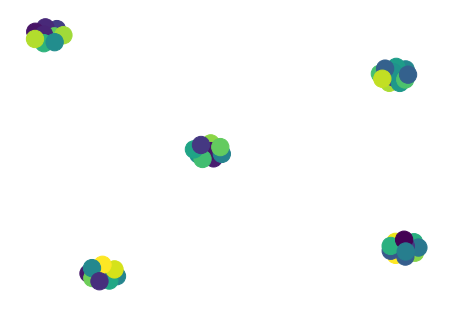

                        0         1
0    [0.9619107455346222]  0.741983
1   [0.06441444674001473]  0.761702
2    [0.7891942715303771]  0.569267
3     [0.177226238283531]  0.522423
4    [0.9440371060941252]  0.655123
5    [0.6091959154527136]  0.414848
6     [0.839591919659533]  0.496539
7    [0.4406367464203794]  0.434026
8    [0.6775089279258867]  0.337116
9   [0.17855500858877416]  0.544234
10  [0.28493851781217705]  0.496223
11  [0.11384921261232228]  0.585800
12   [0.5158618344686122]  0.291048
13   [0.9333196008170971]  0.713392
14  [0.44673635143702617]  0.312503
15   [0.7510065789639694]  0.462093
16  [0.07845944951476702]  0.567326
17     [0.57412693913227]  0.406823
18   [0.5326677331923972]  0.294410
19   [0.4687401068189414]  0.339571
20  [0.35736784515754816]  0.483987
21  [0.05295805297084666]  0.646692
22   [0.4960445674936236]  0.287085
23   [0.6919055562617197]  0.348853
24   [0.8994784804713435]  0.610565
25  [0.38438243606127953]  0.428102
26   [0.7318488841888736]  0

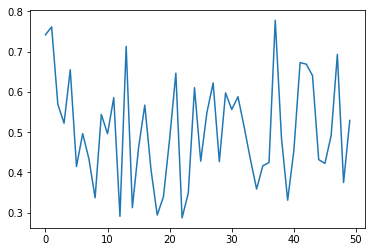

0.5042934937839132
______NOOKS_________
DAY 0


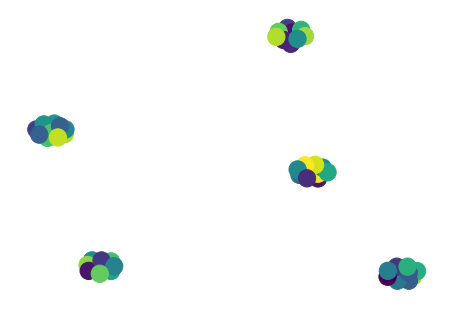

______NETWORK_________


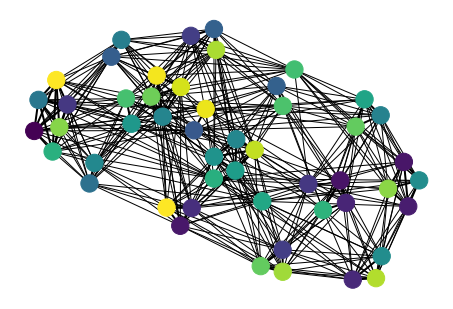

                        0         1
0    [0.9619107455346222]  0.572389
1   [0.06441444674001473]  0.697688
2    [0.7891942715303771]  0.434216
3     [0.177226238283531]  0.671076
4    [0.9440371060941252]  0.486371
5    [0.6091959154527136]  0.526844
6     [0.839591919659533]  0.546190
7    [0.4406367464203794]  0.438573
8    [0.6775089279258867]  0.447077
9   [0.17855500858877416]  0.592126
10  [0.28493851781217705]  0.544729
11  [0.11384921261232228]  0.620218
12   [0.5158618344686122]  0.366797
13   [0.9333196008170971]  0.816270
14  [0.44673635143702617]  0.293765
15   [0.7510065789639694]  0.391336
16  [0.07845944951476702]  0.510470
17     [0.57412693913227]  0.484703
18   [0.5326677331923972]  0.271935
19   [0.4687401068189414]  0.373088
20  [0.35736784515754816]  0.485975
21  [0.05295805297084666]  0.613701
22   [0.4960445674936236]  0.271935
23   [0.6919055562617197]  0.512334
24   [0.8994784804713435]  0.450725
25  [0.38438243606127953]  0.363413
26   [0.7318488841888736]  0

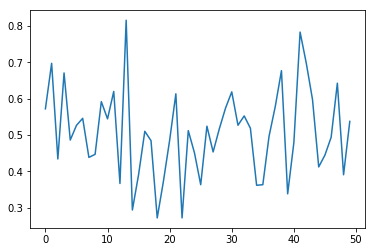

0.5073909085603091
______NOOKS_________
DAY 1


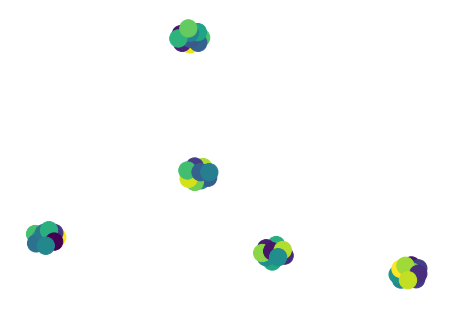

______NETWORK_________


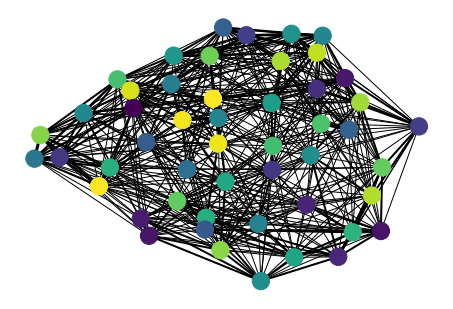

                        0         1
0    [0.9619107455346222]  0.673240
1   [0.06441444674001473]  0.558679
2    [0.7891942715303771]  0.467640
3     [0.177226238283531]  0.406576
4    [0.9440371060941252]  0.354000
5    [0.6091959154527136]  0.427801
6     [0.839591919659533]  0.412562
7    [0.4406367464203794]  0.312360
8    [0.6775089279258867]  0.262646
9   [0.17855500858877416]  0.476797
10  [0.28493851781217705]  0.388734
11  [0.11384921261232228]  0.543013
12   [0.5158618344686122]  0.317221
13   [0.9333196008170971]  0.766130
14  [0.44673635143702617]  0.253694
15   [0.7510065789639694]  0.374049
16  [0.07845944951476702]  0.532460
17     [0.57412693913227]  0.350027
18   [0.5326677331923972]  0.260730
19   [0.4687401068189414]  0.324530
20  [0.35736784515754816]  0.485975
21  [0.05295805297084666]  0.407347
22   [0.4960445674936236]  0.253694
23   [0.6919055562617197]  0.480013
24   [0.8994784804713435]  0.232889
25  [0.38438243606127953]  0.376477
26   [0.7318488841888736]  0

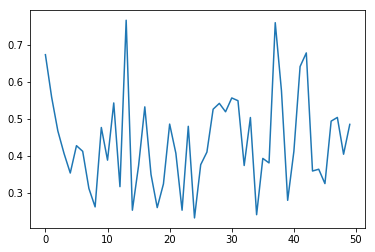

In [ ]:
member_vectors = np.random.random(size=(50, 1))
#print(sorted(member_vectors))
exp = NooksExperiment(member_vectors, alpha=1000)
exp.run(num_nooks=5)

